# Brevitas

## 1 Traditional Binary Neural Network (MNIST)

### 1.1 Importing and checking hardware

In [42]:
import os
import sys
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

# for training model
# import brevitas
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim as optim

# fracbnn modules
sys.path.append('./src')
import utils as util
import quantization as q


# # for dataset
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Checking version
print(f'Torch version: {torch.__version__}')
# i dont get how to use brevitas, many other paper such as fracbnn and reacnet also did not use brevitas actually
# print(f'Brevitas version: {brevitas.__version__}')


# checking hardware
# if torch.cuda.is_available():
print(f'Cuda is available: {torch.cuda.is_available()}')  # should be True
print(f'device: {torch.cuda.get_device_name(0)}')  # should say RTX 3060
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Torch version: 2.8.0+cu128
Cuda is available: True
device: NVIDIA GeForce RTX 3060


## 1.2 Importing dataset

In [2]:
dataset_dir = '/home/jovyan/dataset'


training_data = datasets.MNIST(
    root=dataset_dir,
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root=dataset_dir,
    train=False,
    download=True,
    transform=ToTensor()
)

In [46]:
trainloader = DataLoader(training_data, batch_size=256, shuffle=True)
testloader = DataLoader(test_data, batch_size=256, shuffle=True)

## 1.3 Binary Genetic algorithm

### 1.3.0 Helper

In [24]:
# --- GA Helpers ---
def generate_weight(x, y):
    return 2 * torch.randint(0, 2, (x, y)) - 1  # -1 or 1

def mutate_weight(weight, mutation_rate=0.2):
    x, y = weight.shape
    for i in range(x):
        for j in range(y):
            if random.random() < mutation_rate:
                weight[i, j] *= -1
    return weight

def get_fitness(target, candidate):
    # Fitness = number of matching elements
    return torch.sum(target == candidate).item()

### 1.3.1 Basic

Generation 0: Best fitness = 8
Generation 1: Best fitness = 8
Generation 2: Best fitness = 8
Generation 3: Best fitness = 9
🎯 Found perfect match!


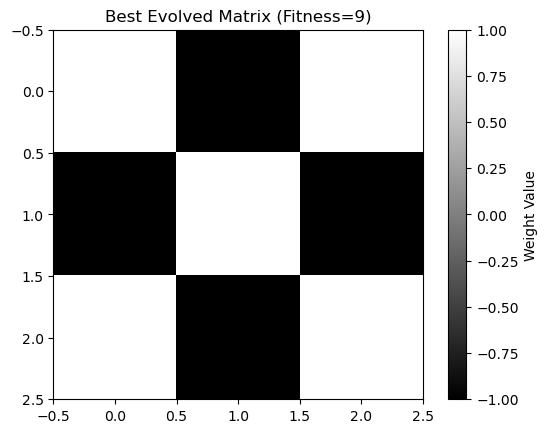

tensor([[ 1, -1,  1],
        [-1,  1, -1],
        [ 1, -1,  1]])


In [25]:
import torch
import random
import matplotlib.pyplot as plt

# Parameters
initial_population = 50
generations = 100
mutation_rate = 0.1
survivor =25



# --- Target ---
target_weight = torch.tensor([[1, -1, 1],
                              [-1, 1, -1],
                              [1, -1, 1]])

# --- Step 1: Initialize population ---
population = [generate_weight(3, 3) for _ in range(initial_population)]

# --- GA Loop ---
for gen in range(generations):
    # Step 2: Evaluate fitness
    fitness_scores = [get_fitness(target_weight, ind) for ind in population]
    
    # Step 3: Select best (elitism: keep top 2)
    sorted_pop = [p for _, p in sorted(zip(fitness_scores, population), key=lambda x: x[0], reverse=True)]
    best = sorted_pop[0]
    best_fitness = max(fitness_scores)
    
    print(f"Generation {gen}: Best fitness = {best_fitness}")
    
    # Stop early if perfect solution found
    if best_fitness == target_weight.numel():
        print("🎯 Found perfect match!")
        break
    
    # Step 4: Create next generation (mutations of top parents)
    new_population = []
    for i in range(initial_population):
        parent = random.choice(sorted_pop[:survivor]).clone()  # pick from top 5
        child = mutate_weight(parent.clone(), mutation_rate)
        new_population.append(child)
    
    population = new_population

# --- Show best solution ---
plt.imshow(best.numpy(), cmap="gray", interpolation="nearest")
plt.colorbar(label="Weight Value")
plt.title(f"Best Evolved Matrix (Fitness={best_fitness})")
plt.show()

print(best)

### 1.3.2 Multi channel

Generation 0: Best fitness = 29
Generation 1: Best fitness = 31
Generation 2: Best fitness = 35
Generation 3: Best fitness = 36
Generation 4: Best fitness = 36
Generation 5: Best fitness = 37
Generation 6: Best fitness = 39
Generation 7: Best fitness = 40
Generation 8: Best fitness = 40
Generation 9: Best fitness = 40
Generation 10: Best fitness = 40
Generation 11: Best fitness = 41
Generation 12: Best fitness = 41
Generation 13: Best fitness = 41
Generation 14: Best fitness = 41
Generation 15: Best fitness = 41
Generation 16: Best fitness = 41
Generation 17: Best fitness = 41
Generation 18: Best fitness = 42
Generation 19: Best fitness = 42
Generation 20: Best fitness = 42
Generation 21: Best fitness = 42
Generation 22: Best fitness = 42
Generation 23: Best fitness = 42
Generation 24: Best fitness = 42
Generation 25: Best fitness = 43
Generation 26: Best fitness = 43
Generation 27: Best fitness = 43
Generation 28: Best fitness = 43
Generation 29: Best fitness = 43
Generation 30: Best 

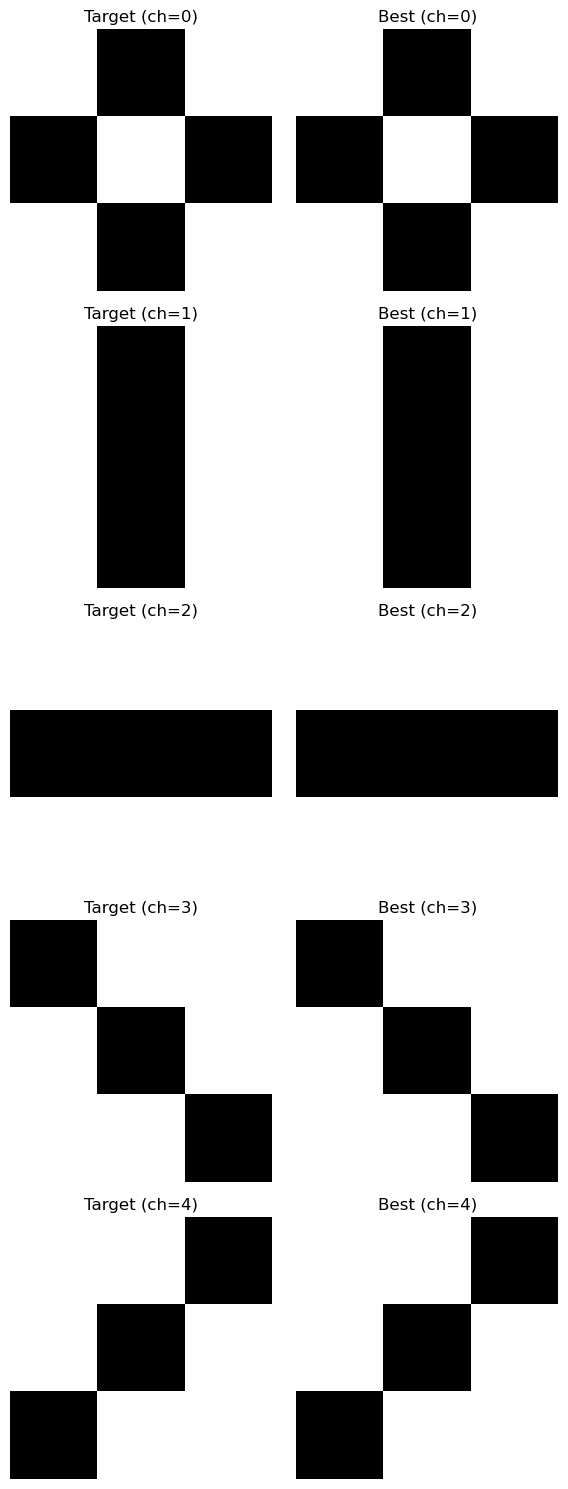

In [35]:
# Multi channel target (5 channel)
target_weight = torch.tensor([[[1, -1, 1],
                              [-1, 1, -1],
                              [1, -1, 1]],

                              [[1, -1, 1],
                              [1, -1, 1],
                              [1, -1, 1]],

                              [[1, 1, 1],
                              [-1, -1, -1],
                              [1, 1, 1]],

                              [[-1, 1, 1],
                              [1, -1, 1],
                              [1, 1, -1]],

                              [[1, 1, -1],
                              [1, -1, 1],
                              [-1, 1, 1]]
                            
                              ])

num_channel = target_weight.shape[0]
population  = 50
generations = 1000

weight = [torch.stack([generate_weight(3, 3) for _ in range(num_channel)]) for _ in range(population)]


# --- GA Loop ---
for gen in range(generations):
    # Step 2: Evaluate fitness
    # population loop
    fitness_scores = []
    for ind in weight:  # each individual is a tensor of shape [num_channel, 3, 3]
        fitness = 0
        for chann in range(num_channel):
            fitness += get_fitness(target_weight[chann], ind[chann])
        fitness_scores.append(fitness)

    # Step 3: Select best (elitism: keep top 2)
    sorted_pop = [p for _, p in sorted(zip(fitness_scores, weight), key=lambda x: x[0], reverse=True)]
    best = sorted_pop[0]
    best_fitness = max(fitness_scores)
    
    print(f"Generation {gen}: Best fitness = {best_fitness}")
    
    # Stop early if perfect solution found
    if best_fitness == target_weight.numel():
        print("🎯 Found perfect match!")
        break
    
    # Step 4: Create next generation (mutations of top parents)
    # Step 4: Create next generation (mutations of top parents)
    weight = []

    for _ in range(population):
        parent = random.choice(sorted_pop[:5]).clone()  # pick a top parent
        child = torch.stack([mutate_weight(parent[ch], mutation_rate) for ch in range(num_channel)])
        new_population.append(child)

    weight = new_population


fig, axes = plt.subplots(num_channel, 2, figsize=(6, 3 * num_channel))

for ch in range(num_channel):
    # Target
    axes[ch, 0].imshow(target_weight[ch].numpy(), cmap="gray", interpolation="nearest")
    axes[ch, 0].set_title(f"Target (ch={ch})")
    axes[ch, 0].axis("off")

    # Best
    axes[ch, 1].imshow(best[ch].numpy(), cmap="gray", interpolation="nearest")
    axes[ch, 1].set_title(f"Best (ch={ch})")
    axes[ch, 1].axis("off")

plt.tight_layout()
plt.show()






## 1.4 Creating VGG-16 binary code

### 1.4.1 Initial VGG using binary weight

In [43]:


class binary_VGG_small(nn.Module):
    def __init__(self, num_classes=10, batch_size=128):
        super(binary_VGG_small, self).__init__()

        ''' The input layer is binarized! '''
        self.conv1 =  q.BinaryConv2d(32, 26, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = q.BinaryConv2d(26, 24, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = q.BinaryConv2d(24, 31, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv4 = q.BinaryConv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True)
        self.binarize = q.QuantSign.apply
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(31*7*7, num_classes)
        num_gpus = 1
        assert batch_size % num_gpus == 0, \
            "Given batch size cannot evenly distributed to available gpus."
        N = batch_size // num_gpus

        self.encoder = q.InputEncoder(input_size=(1,1,28,28), resolution=8)




    def forward(self, x):
        x = self.encoder(x)
        x = self.binarize(self.conv1(x))
        x = self.binarize(self.conv2(x))
        x = self.pool(x)
        x = self.binarize(self.conv3(x))
        x = self.pool(x)
        x = self.flatten(x)
        out = self.linear(x)
        return out


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = binary_VGG_small(num_classes=10).to(device)
# put input on the same device
input = torch.randn(1, 1, 28, 28).to(device)
output = model(input)
print(output)

cuda
tensor([[ 0.4704, -0.0026,  0.3751, -2.0827,  0.0050,  0.2134,  0.8289, -0.4840,
          0.6485,  0.1553]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [47]:
net = binary_VGG_small(num_classes=10).to(device)

criterion = (nn.CrossEntropyLoss().cuda() 
            if torch.cuda.is_available() else nn.CrossEntropyLoss())

best_acc = 0.0
best_model = copy.deepcopy(net.state_dict())
start_epoch =0
num_epoch = 100
initial_lr = 1e-3
weight_decay = 1e-5
last_epoch = -1


optimizer = optim.Adam(net.parameters(),
                          lr = initial_lr,
                          weight_decay=weight_decay)


lr_decay_milestones = [100, 150, 200]
scheduler = optim.lr_scheduler.MultiStepLR(
                            optimizer,
                            milestones=lr_decay_milestones,
                            gamma=0.1,
                            last_epoch=last_epoch)


def sparsity(testloader, net, device):
    num_out, num_high = [], []

    def _report_sparsity(m):
        classname = m.__class__.__name__
        if isinstance(m, q.PGBinaryConv2d):
            num_out.append(m.num_out)
            num_high.append(m.num_high)

    net.eval()
    # initialize cnt_out, cnt_high
    net.apply(_report_sparsity)
    cnt_out = np.zeros(len(num_out))
    cnt_high = np.zeros(len(num_high))
    num_out, num_high = [], []

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            """ calculate statistics per PG layer """
            net.apply(_report_sparsity)
            cnt_out += np.array(num_out)
            cnt_high += np.array(num_high)
            num_out = []
            num_high = []
    print('Sparsity of the update phase: %.1f %%' %
          (100.0-np.sum(cnt_high)*1.0/np.sum(cnt_out)*100.0))


def test_accu(testloader, net, device):
    correct = 0
    total = 0
    # switch the model to the evaluation mode
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    print('Accuracy of the network on the 10000 test images: %.1f %%' % accuracy)
    return accuracy


for epoch in range(start_epoch,num_epoch): # loop over the dataset multiple times

    # set printing functions
    batch_time = util.AverageMeter('Time/batch', ':.2f')
    losses = util.AverageMeter('Loss', ':6.2f')
    top1 = util.AverageMeter('Acc', ':6.2f')
    progress = util.ProgressMeter(
                    len(trainloader),
                    [losses, top1, batch_time],
                    prefix="Epoch: [{}]".format(epoch+1)
                    )

    # switch the model to the training mode
    net.train()

    print('current learning rate = {}'.format(optimizer.param_groups[0]['lr']))
    
    # each epoch
    end = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # for name, param in net.named_parameters():
        #     if 'threshold' in name:
        #         loss += (0.00001 * 0.5 *
        #                     torch.norm(param-args.gtarget) *
        #                     torch.norm(param-args.gtarget))
        loss.backward()
        optimizer.step()

        # measure accuracy and record loss
        _, batch_predicted = torch.max(outputs.data, 1)
        batch_accu = 100.0 * (batch_predicted == labels).sum().item() / labels.size(0)
        losses.update(loss.item(), labels.size(0))
        top1.update(batch_accu, labels.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 100 == 99:    
            # print statistics every 100 mini-batches each epoch
            progress.display(i) # i = batch id in the epoch

    # update the learning rate
    scheduler.step()

    # print test accuracy every few epochs
    if epoch % 1 == 0:
        print('epoch {}'.format(epoch+1))
        epoch_acc = test_accu(testloader, net, device)
        # sparsity(testloader, net, device)
        if epoch_acc >= best_acc:
            best_acc = epoch_acc
            best_model = copy.deepcopy(net.state_dict())
        print("The best test accuracy so far: {:.1f}".format(best_acc))

        # save the model if required
        # if args.save:
        #     print("Saving the trained model and states.")
        #     this_file_path = os.path.dirname(os.path.abspath(__file__))
        #     save_folder = os.path.join(this_file_path, 'save_CIFAR10_model')
        #     util.save_models(best_model, save_folder,
        #             suffix=_ARCH+'-finetune' if args.finetune else _ARCH)
        #     """
        #     states = {'epoch':epoch+1, 
        #                 'optimizer':optimizer.state_dict(), 
        #                 'scheduler':scheduler.state_dict()}
        #     util.save_states(states, save_folder, suffix=_ARCH)
        #     """

print('Finished Training')


current learning rate = 0.001
Epoch: [1][ 99/235]	Loss   0.85	Acc  74.58	Time/batch 0.02
Epoch: [1][199/235]	Loss   0.59	Acc  82.37	Time/batch 0.02
epoch 1
Accuracy of the network on the 10000 test images: 92.8 %
The best test accuracy so far: 92.8
current learning rate = 0.001
Epoch: [2][ 99/235]	Loss   0.25	Acc  92.74	Time/batch 0.02
Epoch: [2][199/235]	Loss   0.24	Acc  92.82	Time/batch 0.02
epoch 2
Accuracy of the network on the 10000 test images: 94.6 %
The best test accuracy so far: 94.6
current learning rate = 0.001
Epoch: [3][ 99/235]	Loss   0.18	Acc  94.59	Time/batch 0.02
Epoch: [3][199/235]	Loss   0.17	Acc  94.79	Time/batch 0.02
epoch 3
Accuracy of the network on the 10000 test images: 95.8 %
The best test accuracy so far: 95.8
current learning rate = 0.001
Epoch: [4][ 99/235]	Loss   0.16	Acc  95.28	Time/batch 0.02
Epoch: [4][199/235]	Loss   0.15	Acc  95.49	Time/batch 0.02
epoch 4
Accuracy of the network on the 10000 test images: 95.9 %
The best test accuracy so far: 95.9
curr

In [28]:
for name, param in net.named_parameters():
    print(name, param.data)


conv1.weight tensor([[[[-3.6147e-02, -5.6324e-02,  4.2087e-02],
          [-1.5825e-02, -6.6599e-02, -3.0793e-02],
          [-4.9579e-02, -4.5765e-02,  5.4359e-02]],

         [[-5.0926e-03, -2.2623e-02,  9.0508e-02],
          [-4.5542e-02,  1.8164e-02,  2.4676e-02],
          [-1.0542e-01,  1.2314e-02, -2.5641e-02]],

         [[-4.5086e-02,  3.1706e-02,  2.6759e-02],
          [-1.1363e-02,  9.8884e-03,  1.0409e-02],
          [-8.4782e-02, -7.2667e-02,  5.7489e-02]],

         ...,

         [[ 9.8576e-03,  2.1478e-02,  1.3151e-01],
          [-3.1922e-02, -9.5062e-03,  1.4333e-01],
          [ 4.7473e-02, -1.0527e-02,  1.3833e-01]],

         [[ 7.3301e-03,  1.2018e-01,  9.2022e-02],
          [ 2.3729e-02,  6.8309e-02,  7.3373e-02],
          [ 3.0666e-02,  4.2969e-02,  9.8334e-02]],

         [[ 6.8416e-02,  1.3557e-01,  1.6545e-01],
          [-3.6064e-04, -9.1317e-03,  1.4463e-01],
          [ 8.5003e-02, -1.9483e-02,  1.1767e-01]]],


        [[[-1.5781e-01, -7.4925e-02, -6.